<h1> Import </h1>


In [1]:
# !pip install transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
from sklearn.model_selection import train_test_split

from transformers import AutoModel, AutoTokenizer 
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

import optuna
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
train = pd.read_csv('/kaggle/input/wb_winter_24/train.csv')
test = pd.read_csv('/kaggle/input/wb_winter_24/test.csv')

In [4]:
len(train)

240159

<h1> Предобработка данных </h1>

<h2>Очистка данных</h2>

In [5]:
def cleaning(text):
    
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # если несколько пробелов между слов, заменим на один
    text = re.sub(r'ё', 'е', text)  # заменим буквы 'ё' на 'е', чтобы часть слов определялась как одни и те же, а не разные
    text = emoji.replace_emoji(text, replace='')  # эмодзи удалим
    
    return text
    

In [6]:
train['cl_text'] = train['text'].apply(cleaning)
test['cl_text'] = test['text'].apply(cleaning)

<h2> Проверка данных на сбалансированность  </h2>

In [7]:
print(f'с нецензурными словами: {len(train[(train.label==1)])}')
print(f'без нецензурных слов: {len(train[(train.label==0)])}')

с нецензурными словами: 29698
без нецензурных слов: 210461


Text(0, 0.5, 'количество слов')

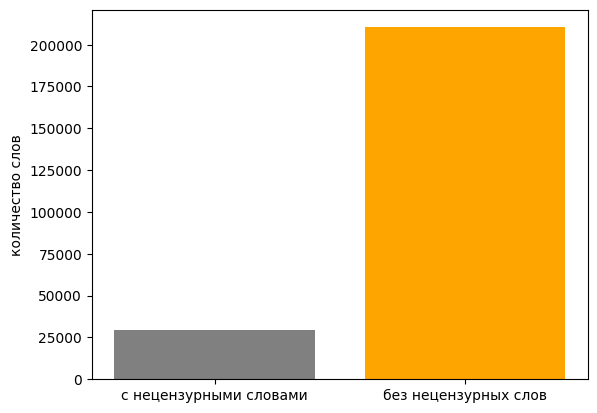

In [8]:
plt.bar(['c нецензурными словами', 'без нецензурных слов'], [len(train[train.label == 1]), len(train[train.label == 0])], color = ['grey', 'orange'] )
plt.ylabel("количество слов")

**Данные несбалансированы, необходимо в дальнейшем учитывать это**

<h1>Разбивка train </h1>

**Разобьем train на валидационный датасет и тестовый для подбора гиперпараметров и оценки метрик**

In [9]:
train_d, temp_d = train_test_split(train, test_size=0.2, random_state=1)
val_d, test_d = train_test_split(temp_d, test_size=0.5, random_state=1)

In [10]:
train_d

,ID,text,label,cl_text
113240,113240,неплохие,0,неплохие
167002,167002,"Хочется поставить 10 звезд,отличная игра,как в...",0,"хочется поставить 10 звезд,отличная игра,как в..."
82986,82986,"Спасибо, понравилось, держит",0,"спасибо, понравилось, держит"
19319,19319,"Купила в подарок, очень понравился, спасибо пр...",0,"купила в подарок, очень понравился, спасибо пр..."
136255,136255,Очень удобный в использовании плотная резина и...,0,очень удобный в использовании плотная резина и...
...,...,...,...,...
229119,229119,"Красивые удобные, нигде не жмет. 11кг-размер 80)",0,"красивые удобные, нигде не жмет. 11кг-размер 80)"
5192,5192,"Дристала неделю, а так вкусненько 🤤",1,"дристала неделю, а так вкусненько"
208780,208780,"Очень хорошее средство, стоит покупать. Одуван...",0,"очень хорошее средство, стоит покупать. одуван..."
229611,229611,Отличные кроссовки. Яркие. Удобные. Прекрасное...,0,отличные кроссовки. яркие. удобные. прекрасное...


<h1> Токенизация для трансформера RuBERT </h1>

In [11]:
model_name = "DeepPavlov/rubert-base-cased" # модель

tokenizer = AutoTokenizer.from_pretrained(model_name) # tokenizer

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in  val_d['text']]
avg_length = np.mean(token_lengths)

print(f"cр.длина текста в токенах: {avg_length}")

cр.длина текста в токенах: 24.78759993337775


Поскольку у нас работает Центральная предельня теорема, я просто использовала валидационный датасет для поиска среднего количества слов, возьмем max_length = 40 с запасом

In [13]:
def tokenize_data(dataset):
    
    texts = dataset['cl_text'].dropna().tolist()  # преобразуем в список для токенайзера
    
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=40,
        return_tensors='pt')

In [14]:
train_tokens = tokenize_data(train_d)
val_tokens = tokenize_data(val_d)
test_tokens = tokenize_data(test_d)

<h2> Настройка модели для нашей задачи классификации</h2>

In [15]:
from transformers import AutoModelForSequenceClassification


num_labels = 2 # (2 класса - с нецензурными словами и без)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Теперь модель настроена для классификации

<h1>TensorDataset и Dataloader</h1>

In [16]:
train_labels = torch.tensor(train_d['label'].values) # тензор меток для трейна и валидационного сетов
val_labels = torch.tensor(val_d['label'].values)
test_labels = torch.tensor(test_d['label'].values) # для проверочного теста, в оригинальном неь лейблов

In [17]:
train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], train_labels) # TensorDataset для всех сетов
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], val_labels)
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], test_labels) 

In [18]:

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True) # dataloader для всех сетов
val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = False) 

**У нас несбалансированные данные, рассчитаем веса классов для учета дисбаланса**

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [20]:
class_counts = train_d['label'].value_counts()
class_weights = [len(train_d) / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights).to(device).float()

In [21]:
criterion = CrossEntropyLoss(weight=class_weights) # определяем функцию потерь с учетом весов классов

**Optimisator**

Наилучшие параметры из прошлой версии:

In [22]:
from transformers import AdamW, get_linear_schedule_with_warmup # scedule для регулирования lr

optimizer = AdamW(model.parameters(), lr=8.15230295742077e-06)

epochs = 3  # количество эпох и lr для rubert трансформеров предлагают часто такие значения (3-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
import torch
from torch.nn import CrossEntropyLoss


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [24]:
for epoch in range(epochs):
    print(f'epoch {epoch + 1}/{epochs}')
    
    model.train()  
    total_train_loss = 0
    
    for batch in train_dataloader:

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, b_labels) 
        total_train_loss += loss.item()
        
        loss.backward()

        
        optimizer.step() 
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"average training loss: {avg_train_loss:.3f}")

epoch 1/3
average training loss: 0.123
epoch 2/3
average training loss: 0.079
epoch 3/3
average training loss: 0.053


**Валидация**

In [25]:
model.eval()  
total_val_accuracy = 0
total_val_loss = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, b_labels)  
        total_val_loss += loss.item()

        predictions = torch.argmax(logits, dim=-1)
        total_val_accuracy += (predictions == b_labels).sum().item()

        all_labels.extend(b_labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

avg_val_loss = total_val_loss / len(val_dataloader)
avg_val_accuracy = total_val_accuracy / len(val_d)
val_f1_score = f1_score(all_labels, all_predictions, average='weighted')

print(f"validation loss: {avg_val_loss:.3f}")
print(f"validation accuracy: {avg_val_accuracy:.3f}")
print(f"validation F1 score: {val_f1_score:.3f}")

validation loss: 0.120
validation accuracy: 0.976
validation F1 score: 0.976


**Тестирование**

In [26]:
model.eval() 
all_test_labels = []
all_test_predictions = []
total_test_loss = 0

with torch.no_grad():
    for batch in test_dataloader:

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, b_labels)  # используем взвешенную функцию потерь
        total_test_loss += loss.item()

        predictions = torch.argmax(logits, dim=-1)
        all_test_labels.extend(b_labels.cpu().numpy())
        all_test_predictions.extend(predictions.cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataloader)
test_f1_score = f1_score(all_test_labels, all_test_predictions, average='weighted')
print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test F1 Score: {test_f1_score:.3f}")

Test Loss: 0.119
Test F1 Score: 0.976


<h1>Настройка гиперпараметров для модели с Optune</h1>

**Я взяла примерный range параметров, который обычно используют для fine-tune RuBert моделей**

In [27]:
best_f1 = -float('inf')
best_model_state = None

def parametrization(trial):
    try:
        lr = trial.suggest_float('lr', 2e-6, 2e-5, log=True)
        num_warmup_steps = trial.suggest_int('num_warmup_steps', 0, 500)
        epochs = trial.suggest_int('epochs', 3, 4)
        optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08) # часто finr-tune с такими параметрами для оптимизатора

        total_steps = len(train_dataloader) * epochs 
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

        criterion = CrossEntropyLoss(weight=class_weights) # функция потери с учетом весов

        # обучаем
        model.to(device)
        for epoch in range(epochs):
            model.train()
            for batch in train_dataloader:
                b_input_ids = batch[0].to(device)
                b_attention_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                model.zero_grad()
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
                logits = outputs.logits
                loss = criterion(logits, b_labels)
                loss.backward()

                optimizer.step()
                scheduler.step()

        # валидация
        model.eval()
        all_val_labels = []
        all_val_predictions = []

        with torch.no_grad():
            for batch in val_dataloader:
                b_input_ids = batch[0].to(device)
                b_attention_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                outputs = model(b_input_ids, attention_mask=b_attention_mask)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)

                all_val_labels.extend(b_labels.cpu().numpy())
                all_val_predictions.extend(predictions.cpu().numpy())

        val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted') #  f1-score

        print(f"trial {trial.number}:")
        print(f"lr: {lr}, num warmup steps: {num_warmup_steps}, epochs: {epochs}\n")
        print(f"val f1-score: {val_f1:.3f}\n")

        global best_f1, best_model_state
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict()

        return val_f1
    except:
        print(f"Ошибка при trial {trial.number}: {e}")
        return 0 
        


# исследования Optuna
study = optuna.create_study(direction='maximize')
study.optimize(parametrization, n_trials=5)  # число испытаний


model.load_state_dict(best_model_state)
print("best f1-score на валидации ", best_f1) # загрузка наилучших весов модели для трейна

[I 2024-11-05 21:28:47,968] A new study created in memory with name: no-name-a768fcc4-cf05-4346-b146-af0a762247d8
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2024-11-05 23:09:30,160] Trial 0 finished with value: 0.9808778463204982 and parameters: {'lr': 3.4900926185648676e-06, 'num_warmup_steps': 140, 'epochs': 4}. Best is trial 0 with value: 0.9808778463204982.


trial 0:
lr: 3.4900926185648676e-06, num warmup steps: 140, epochs: 4

val f1-score: 0.981



/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2024-11-06 00:25:12,099] Trial 1 finished with value: 0.981055415148398 and parameters: {'lr': 6.687521561984681e-06, 'num_warmup_steps': 357, 'epochs': 3}. Best is trial 1 with value: 0.981055415148398.


trial 1:
lr: 6.687521561984681e-06, num warmup steps: 357, epochs: 3

val f1-score: 0.981



/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2024-11-06 01:40:54,075] Trial 2 finished with value: 0.9794602467273072 and parameters: {'lr': 1.4107953542034764e-05, 'num_warmup_steps': 81, 'epochs': 3}. Best is trial 1 with value: 0.981055415148398.


trial 2:
lr: 1.4107953542034764e-05, num warmup steps: 81, epochs: 3

val f1-score: 0.979



/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2024-11-06 02:56:35,703] Trial 3 finished with value: 0.9787954439410508 and parameters: {'lr': 1.3263838696410552e-05, 'num_warmup_steps': 475, 'epochs': 3}. Best is trial 1 with value: 0.981055415148398.


trial 3:
lr: 1.3263838696410552e-05, num warmup steps: 475, epochs: 3

val f1-score: 0.979



/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2024-11-06 04:12:29,021] Trial 4 finished with value: 0.9793652516276636 and parameters: {'lr': 2.1183170278371398e-06, 'num_warmup_steps': 231, 'epochs': 3}. Best is trial 1 with value: 0.981055415148398.


trial 4:
lr: 2.1183170278371398e-06, num warmup steps: 231, epochs: 3

val f1-score: 0.979

best f1-score на валидации  0.981055415148398


In [28]:
best_trial = study.best_trial
best_params = best_trial.params
print(best_params)

{'lr': 6.687521561984681e-06, 'num_warmup_steps': 357, 'epochs': 3}


`Лучшие параметры:`

- lr: `6.687521561984681e-06`
- num warmup steps: `357`
- epochs: `3`
- val f1-score: `0.981`

**ТЕСТ**

In [32]:
model.eval() 
all_test_labels = []
all_test_predictions = []
total_test_loss = 0

with torch.no_grad():
    for batch in test_dataloader:

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, b_labels)  
        total_test_loss += loss.item()

        predictions = torch.argmax(logits, dim=-1)
        all_test_labels.extend(b_labels.cpu().numpy())
        all_test_predictions.extend(predictions.cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataloader)
test_f1_score = f1_score(all_test_labels, all_test_predictions, average='weighted')
print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test F1 Score: {test_f1_score:.3f}")

Test Loss: 0.339
Test F1 Score: 0.980


**Оригинальный тест**

In [33]:
org_test_tokens = tokenize_data(test)

org_test_dataset = TensorDataset(org_test_tokens['input_ids'], org_test_tokens['attention_mask'])
org_test_dataloader = DataLoader(org_test_dataset, batch_size = 8, shuffle = False)

model.eval()

org_test_predictions = []

with torch.no_grad():
    for batch in org_test_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)

        org_test_predictions.extend(predictions.cpu().numpy())

test_ids = list(range(len(org_test_predictions)))  #индексы
predictions_df = pd.DataFrame({'ID': test_ids, 'label': org_test_predictions})
predictions_df.to_csv('submission.csv', index=False, lineterminator='\n')

`Наилучший результат в моем случае показала версия модели без применения дополнительных методов, таких как аугментация данных, дополнительная очистка или использование более крупной параметризованной модели, например, ruBERT-large`